In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from utils.config import fill_na
warnings.filterwarnings('ignore')
from pathlib import Path


base_path = Path(os.path.abspath('.')) / 'assert'
doc_name = "因子分析阶段表格数据"
digital = pd.read_csv('./data/数字化单位及数字化程度(未筛选).csv', dtype={"股票代码": 'object',"行业代码":"object"},parse_dates=['上市日期'])
dataset = pd.read_csv('./data/2014-2023目标企业绩效指标数据(未处理).csv', dtype={"股票代码": 'object'})
dataset = pd.merge(digital, dataset, how='left',on=['股票代码','截止日期'])
del digital

dataset = dataset[(dataset['截止日期']>2014)&(~dataset['股票简称'].isna())]
dataset['行业代码'] = dataset['行业代码'].apply(lambda x: int(float(x)))
dataset["股票简称"] = dataset["股票简称"].apply(lambda x: x.upper())
for name in ["员工数目", "董事人数","独董人数",'发明专利','两职合一']:
    dataset.loc[:,name].fillna(-1, inplace=True)
    dataset[name] = dataset[name].apply(lambda x: int(x) if x!=-1 else pd.NA)


dataset.loc[:,'发明专利'].fillna(0, inplace=True)
dataset.loc[:,'专利'].fillna(0, inplace=True)
dataset.loc[:,'wufei'].fillna(0, inplace=True)
dataset.loc[:,'yuanchun'].fillna(0, inplace=True)
dataset.loc[:,'zhaochenyv'].fillna(0, inplace=True)
dataset.loc[:,'lishouxi'].fillna(0, inplace=True)
dataset.loc[:,'两职合一'].fillna(2, inplace=True)
dataset.loc[:,'两职合一'].replace(2, 0, inplace=True)
dataset.drop(['纳税总额','社会捐赠额', "股东总数", '员工人数', '研发人员数量', "研发投入金额", "总经理持股比例", "董事长持股比例", "股权性质编码"], axis=1, inplace=True)
dscids = []
# 剔除st企业：这里主要剔除，2020年以后三年内企业状态存在非正常的企业，只要存在一年就剔除
for scid in set(dataset["股票代码"].tolist()):
    cdata = dataset[(dataset["股票代码"]==scid)&(dataset["截止日期"]>2020)]
    flag = cdata[~(cdata["上市状态"]=="正常上市")|(cdata["股票简称"].str.contains("ST"))].shape[0]
    if flag:
        dscids.append(scid)

dataset = dataset[~dataset["股票代码"].isin(dscids)]
dataset['发明专利申请数'] = dataset['发明专利'].apply(lambda x: np.log(1+x))
dataset['独董比例(%)'] = dataset['独董人数']/dataset['董事人数']
dataset['现金资产比率(%)'] = dataset['经营活动产生的现金流量净额']/dataset['总资产']
dataset['员工人均营收比(%)'] = dataset['营业总收入'] / (dataset['员工数目']*1e6)
dataset['提供岗位增长率(%)'] = dataset.groupby('股票代码')['员工数目'].pct_change(1, fill_method='ffill')
dataset['员工收入增长率(%)'] = dataset.groupby('股票代码')['应付职工薪酬'].pct_change(1, fill_method='ffill')
dataset['董事会规模'] = dataset['董事人数'].apply(lambda x: np.log(1+x))
dataset['提供岗位增长率(%)'].replace(to_replace=np.inf, value=pd.NA, inplace=True)
dataset['员工收入增长率(%)'].replace(to_replace=np.inf, value=pd.NA, inplace=True)
dataset['员工收入增长率(%)'] = dataset['员工收入增长率(%)']*100
dataset['提供岗位增长率(%)'] = dataset['提供岗位增长率(%)']*100
dataset['固定资产数字化'] = dataset['固定资产数字化']*100
dataset['无形资产数字化'] = dataset['无形资产数字化']*100
dataset['董事会规模'].replace(to_replace=np.inf, value=pd.NA, inplace=True)

dataset.drop(['发明专利', '专利', "独董人数",'董事人数',"经营活动产生的现金流量净额","总资产","营业总收入",'应付职工薪酬',"上市状态",'员工数目',"托宾Q值"], axis=1, inplace=True)

dataset = fill_na(dataset)
dataset.rename(columns={"资本收益率":"资本收益率(%)","营业利润率":"营业利润率(%)","成本费用利润率": "成本费用利润率(%)", "研发投入占营业收入比例(%)":"研发营收比(%)","研发人员数量占比(%)":"研发人员占比(%)",'经营活动产生的现金流量净额／流动负债':"现金流动负债比率(%)", "数字技术应用z":"数字技术应用", "互联网商业模式z": "商业模式变革", "智能制造z":"智能制造", "现代信息系统z": "现代信息系统","客户集中度":"客户集中度(%)","供应商集中度":"供应商集中度(%)","投入资本回报率(ROIC)":"投入资本回报率(%)","净资产收益率(ROE)":"净资产收益率(%)",'固定资产数字化':"硬件投入占固定资产比重(%)", '无形资产数字化':"软件投入占无形资产比重(%)","EBITDA率":"EBITDA率(%)","资产负债率": "资产负债率(%)", "速动比率":"速动比率(%)", "长期资本负债率":"长期资本负债率(%)", "营业总收入增长率":"营业收入增长率(%)", "资本保值增值率":"资本保值增值率(%)","总资产增长率":"总资产增长率(%)", "资本积累率":"资本积累率(%)", "营业利润增长率":"营业利润增长率(%)","资产报酬率":"资产报酬率(%)",'权益乘数':'权益乘数(%)'}, inplace=True)

dataset = dataset[dataset['截止日期']>2020]
dataset = dataset.sort_values(["股票代码", "截止日期"]).reset_index(drop=True)
print(f"合计获得2021年及以后数据样本{dataset.shape[0]}个，其中2023年数据样本{dataset[dataset['截止日期']==2023].shape[0]}个。")
dataset.dropna(inplace=True)
# dataset.head(10)

合计获得2021年及以后数据样本8059个，其中2023年数据样本2862个。


In [2]:
import mapclassify as mc

# 在数字化企业的筛选中，分别选择了吴非、赵晨宇、袁淳、csmar等数据，首先剔除在某个指标上表现很差的企业，其次以csmar数字化为基础筛选排名前0.1的企业
# print(mc.NaturalBreaks(dataset['zhaochenyv'], 10))
digital = dataset[(dataset["csmar"]>38)&(dataset["wufei"]>1)&(dataset["yuanchun"]>1)&(dataset["zhaochenyv"]>1)&(dataset["lishouxi"]>0.1)].copy(deep=True)

# 保留大概300个样本
units=[]
stocks = list(set(digital['股票代码'].tolist()))
for stock in stocks:
    cdata = digital[digital['股票代码']==stock]
    if len(cdata)==3:
        units.append(stock)

digital = digital[digital['股票代码'].isin(units)].sort_values(['股票代码','截止日期']).reset_index(drop=True)
digital.drop(["wufei", "zhaochenyv", "yuanchun", "lishouxi", "csmar", "上市日期", '硬件投入占固定资产比重(%)', "软件投入占无形资产比重(%)", "两职合一", '销售期间费用率'], axis=1, inplace=True)
# data2023 = digital.reset_index(drop=True).sort_values("股票代码")
data2023 = digital[digital['截止日期']==2023].reset_index(drop=True).sort_values("股票代码")
data2023.drop(["截止日期"], axis=1, inplace=True)
print(f"筛选出2021年及以后数字化企业{digital.shape[0]}个，共保留数据{data2023.shape[0]}个")
del digital
# data2023.head(10)

筛选出2021年及以后数字化企业1146个，共保留数据382个


In [3]:
from utils.config import EvaluationIndicatorTable, pos_indicators
from utils.output import table_translate
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

# 将构建的指标体系转化为表格形式
ind_table = pd.DataFrame(EvaluationIndicatorTable)
table_translate(ind_table, filename=doc_name, table_name="评价指标体系表")
for name in pos_indicators:
    max_ = data2023[name].max()
    data2023[name] = data2023[name].apply(lambda x:max_-x)

data = data2023.set_index("股票简称")[ind_table["指标层"].tolist()].astype('float').copy(deep=True)
mo_all, kmo_model = calculate_kmo(data)
chi_square, p = calculate_bartlett_sphericity(data)
print(f"KMO统计量的值为：{kmo_model:.4f}")
print(f"在{p:.3f}的显著水平下，近似卡方{chi_square:.3f}，球形检验拒绝相关阵为单位阵的原假设，说明做因子分析的效果还可以。")

KMO统计量的值为：0.7474
在0.000的显著水平下，近似卡方7982.017，球形检验拒绝相关阵为单位阵的原假设，说明做因子分析的效果还可以。


In [4]:
from factor_analyzer.factor_analyzer import FactorAnalyzer


# 首先确定需要保留多少个主成分
fa= FactorAnalyzer(n_factors=data.shape[1], rotation=None, method='principal')
fa.fit(data)
# 依次计算各类方差贡献率
eig_df = pd.DataFrame(fa.get_eigenvalues()[1], columns=["总计"])
# eig_df = eig_df.sort_values("总计", ascending=False)
eig_df['方差贡献率(%)'] = eig_df["总计"].apply(lambda x:x*100/sum(eig_df["总计"]))
eig_df['累积贡献率(%)'] = eig_df['方差贡献率(%)'].cumsum()

# 因子分析建模: 最大方差旋转
n_factors=9
fa= FactorAnalyzer(n_factors=n_factors, rotation='varimax', method='principal')
fa.fit(data)

# 旋转后解析结果
eig_table = eig_df[:n_factors].copy(deep=True)
eig_table["总计2"] = np.sum(np.square(fa.loadings_), axis=0)
eig_table["方差贡献率2(%)"] = eig_table["总计2"].apply(lambda x : x/eig_df["总计"].sum()*100)
eig_table["累积贡献率2(%)"] = eig_table["方差贡献率2(%)"].cumsum()
eig_table = eig_table.round(3)
eig_table.columns= [i for i in range(6)]
eig_table.loc[-1] = ["总计", "方差贡献率(%)", "累积贡献率(%)", "总计", "方差贡献率(%)", "累积贡献率(%)"]
eig_table.loc[-2] = ["提取载荷平方和","提取载荷平方和","提取载荷平方和","旋转载荷平方和","旋转载荷平方和","旋转载荷平方和"]
eig_table.index +=2
eig_table.sort_index(inplace=True)
table_translate(eig_table, filename=doc_name, table_name="方差解释率表")
eig_table

,0,1,2,3,4,5
0,提取载荷平方和,提取载荷平方和,提取载荷平方和,旋转载荷平方和,旋转载荷平方和,旋转载荷平方和
1,总计,方差贡献率(%),累积贡献率(%),总计,方差贡献率(%),累积贡献率(%)
2,5.773,18.040,18.040,4.528,14.149,14.149
3,4.569,14.277,32.317,2.944,9.200,23.350
4,2.370,7.406,39.723,2.693,8.415,31.765
5,1.847,5.771,45.494,1.882,5.882,37.647
6,1.725,5.392,50.885,3.095,9.671,47.319
7,1.380,4.314,55.199,2.053,6.416,53.734
8,1.278,3.994,59.193,1.324,4.137,57.871
9,1.186,3.705,62.898,1.286,4.019,61.890


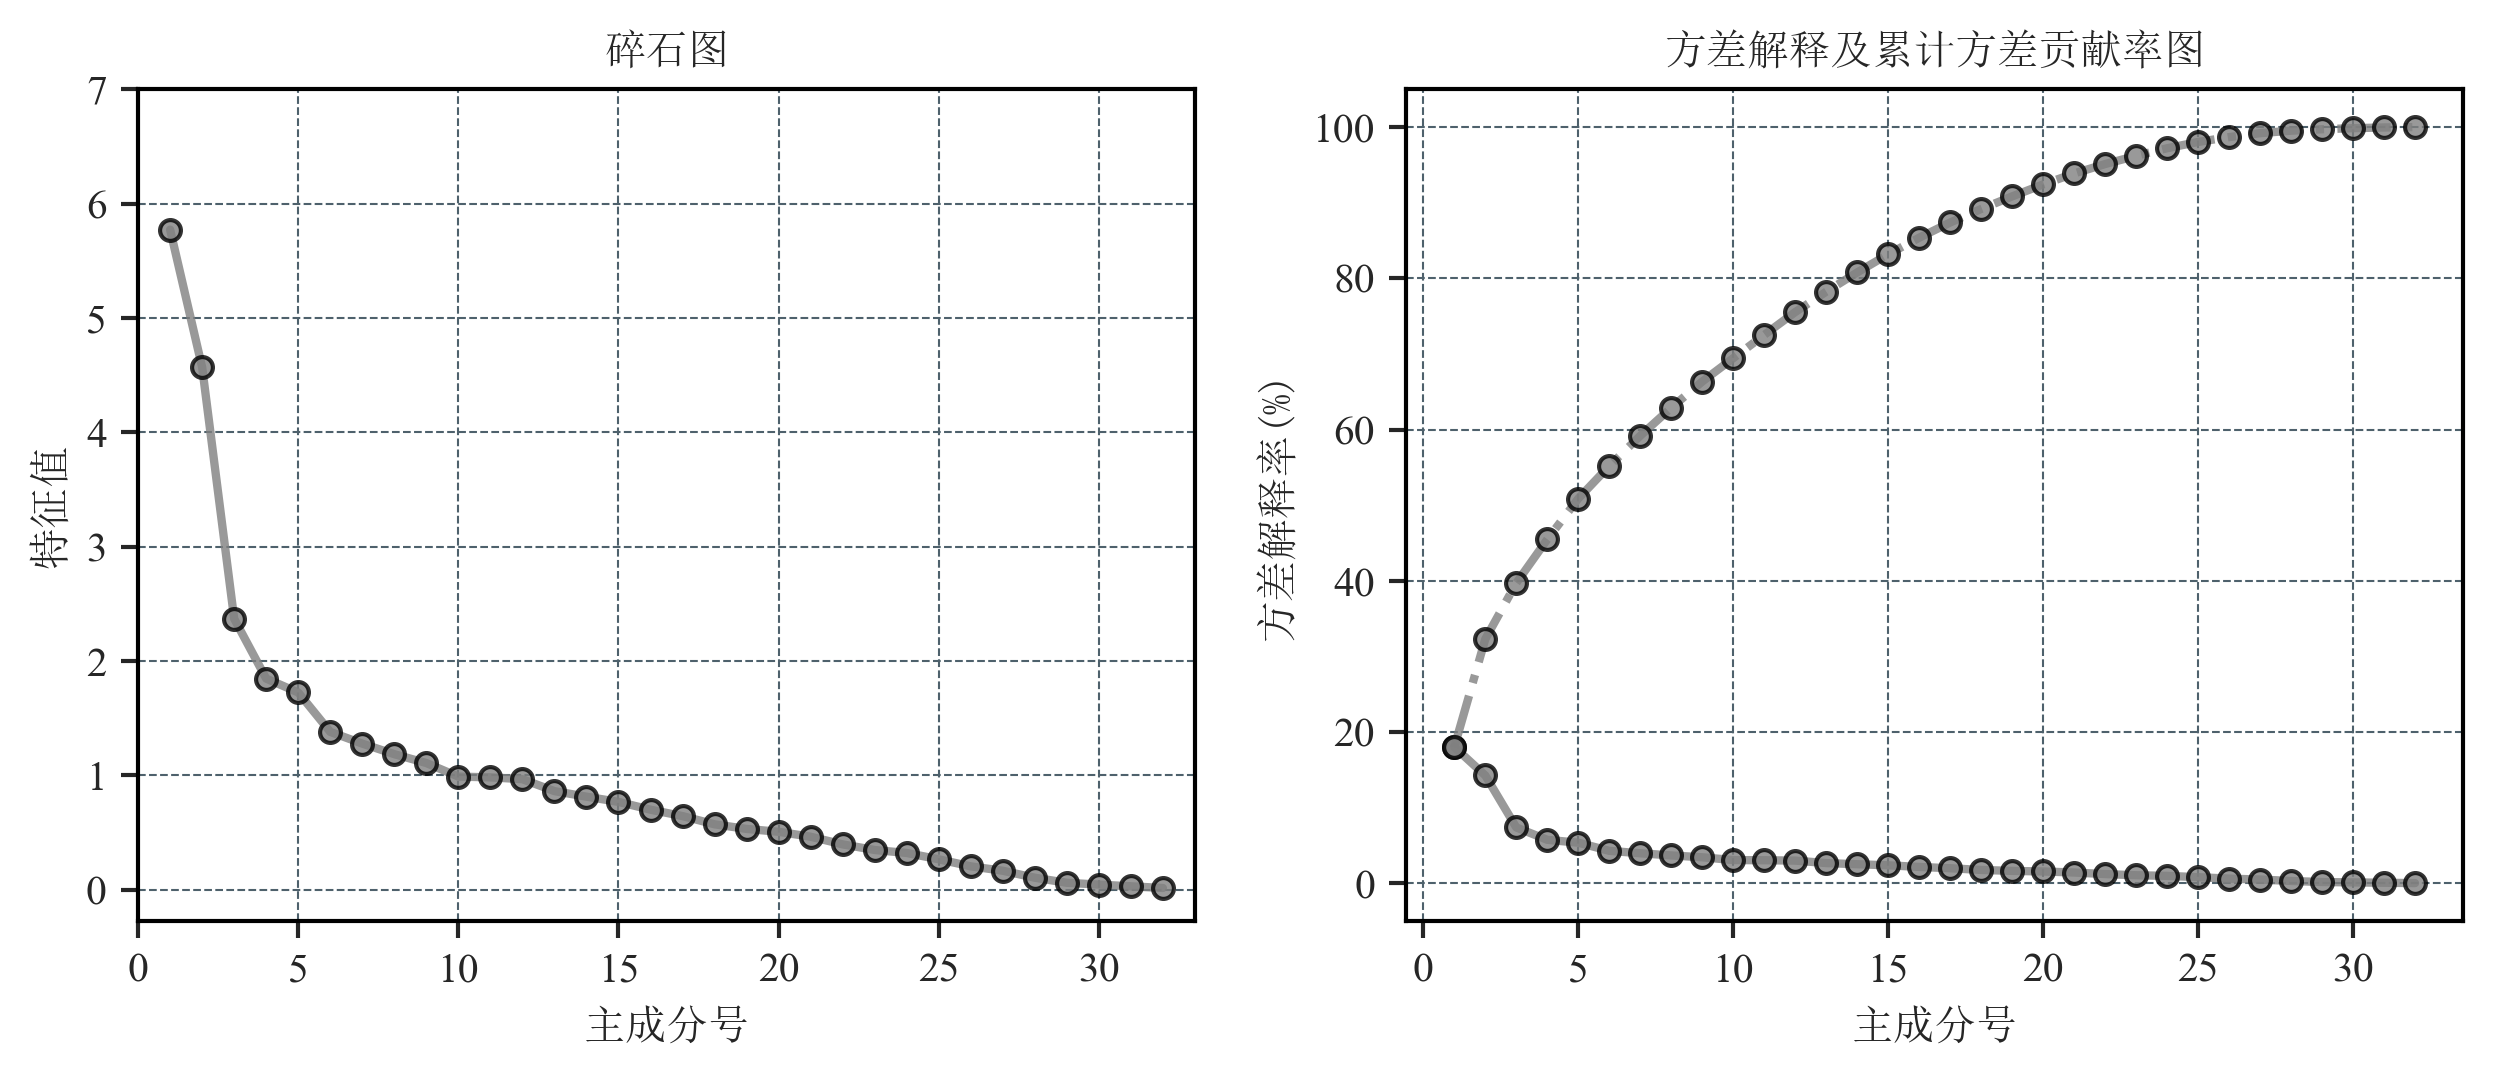

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

alpha=0.8
linewidth = 2
color = 'grey'
marker = "o"
markersize = 5
markeredgecolor = 'k'
markeredgewidth = 1
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6), dpi=300)

# font = {"fontsize":10, "fontfamily": "Songti SC"}  
font = {"fontsize":10, "fontfamily": "simsun"}  
names = range(1, eig_df.shape[0]+1)
ax1.set_title("碎石图", fontdict=font, fontweight='heavy')
ax1.plot(names, eig_df['总计'], linestyle='-', linewidth=linewidth, color=color , marker =marker,markeredgecolor=markeredgecolor, alpha=alpha, markersize=markersize,markeredgewidth=markeredgewidth)
# ax1.axhlineine(y=eig_df['总计'].sum()/len(eig_df['总计'])+0.1, xmin=-1.5, xmax=10, color='black', linestyle=':')
ax1.set_xlabel("主成分号", fontdict=font)
ax1.set_ylabel("特征值", fontdict=font)
ax1.set_xticks(range(eig_df.shape[0]+1)[::5])
ax1.tick_params(direction='out', length=4, width=1, bottom=True, left=True)
ax1.set_xlim(0, eig_df.shape[0]+1)
ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax1.grid(linestyle="--",lw=0.5, color="#4E616C")
for spine in ax1.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("black")

ax2.set_title("方差解释及累计方差贡献率图", fontdict=font, fontweight='heavy')
ax2.plot(names, eig_df['方差贡献率(%)'], linestyle='-', linewidth=linewidth, color=color , marker =marker,markeredgecolor=markeredgecolor,alpha=alpha,markersize=markersize,markeredgewidth=markeredgewidth)
ax2.plot(names, eig_df['累积贡献率(%)'], linestyle='-.', linewidth=linewidth, color=color , marker =marker,markeredgecolor=markeredgecolor,alpha=alpha,markersize=markersize, markeredgewidth=markeredgewidth)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.tick_params(direction='out', length=4, width=1, bottom=True, left=True)
ax2.set_xlabel("主成分号", fontdict=font)
ax2.set_ylabel("方差解释率(%)", fontdict=font)
ax2.set_xticks(range(eig_df.shape[0]+1)[::5])
ax2.grid(linestyle="--",lw=0.5, color="#4E616C")
for spine in ax2.spines.values():
    spine.set_linewidth(1)
    spine.set_edgecolor("black")
plt.savefig(base_path/'imgs/碎石图.svg', bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.show()

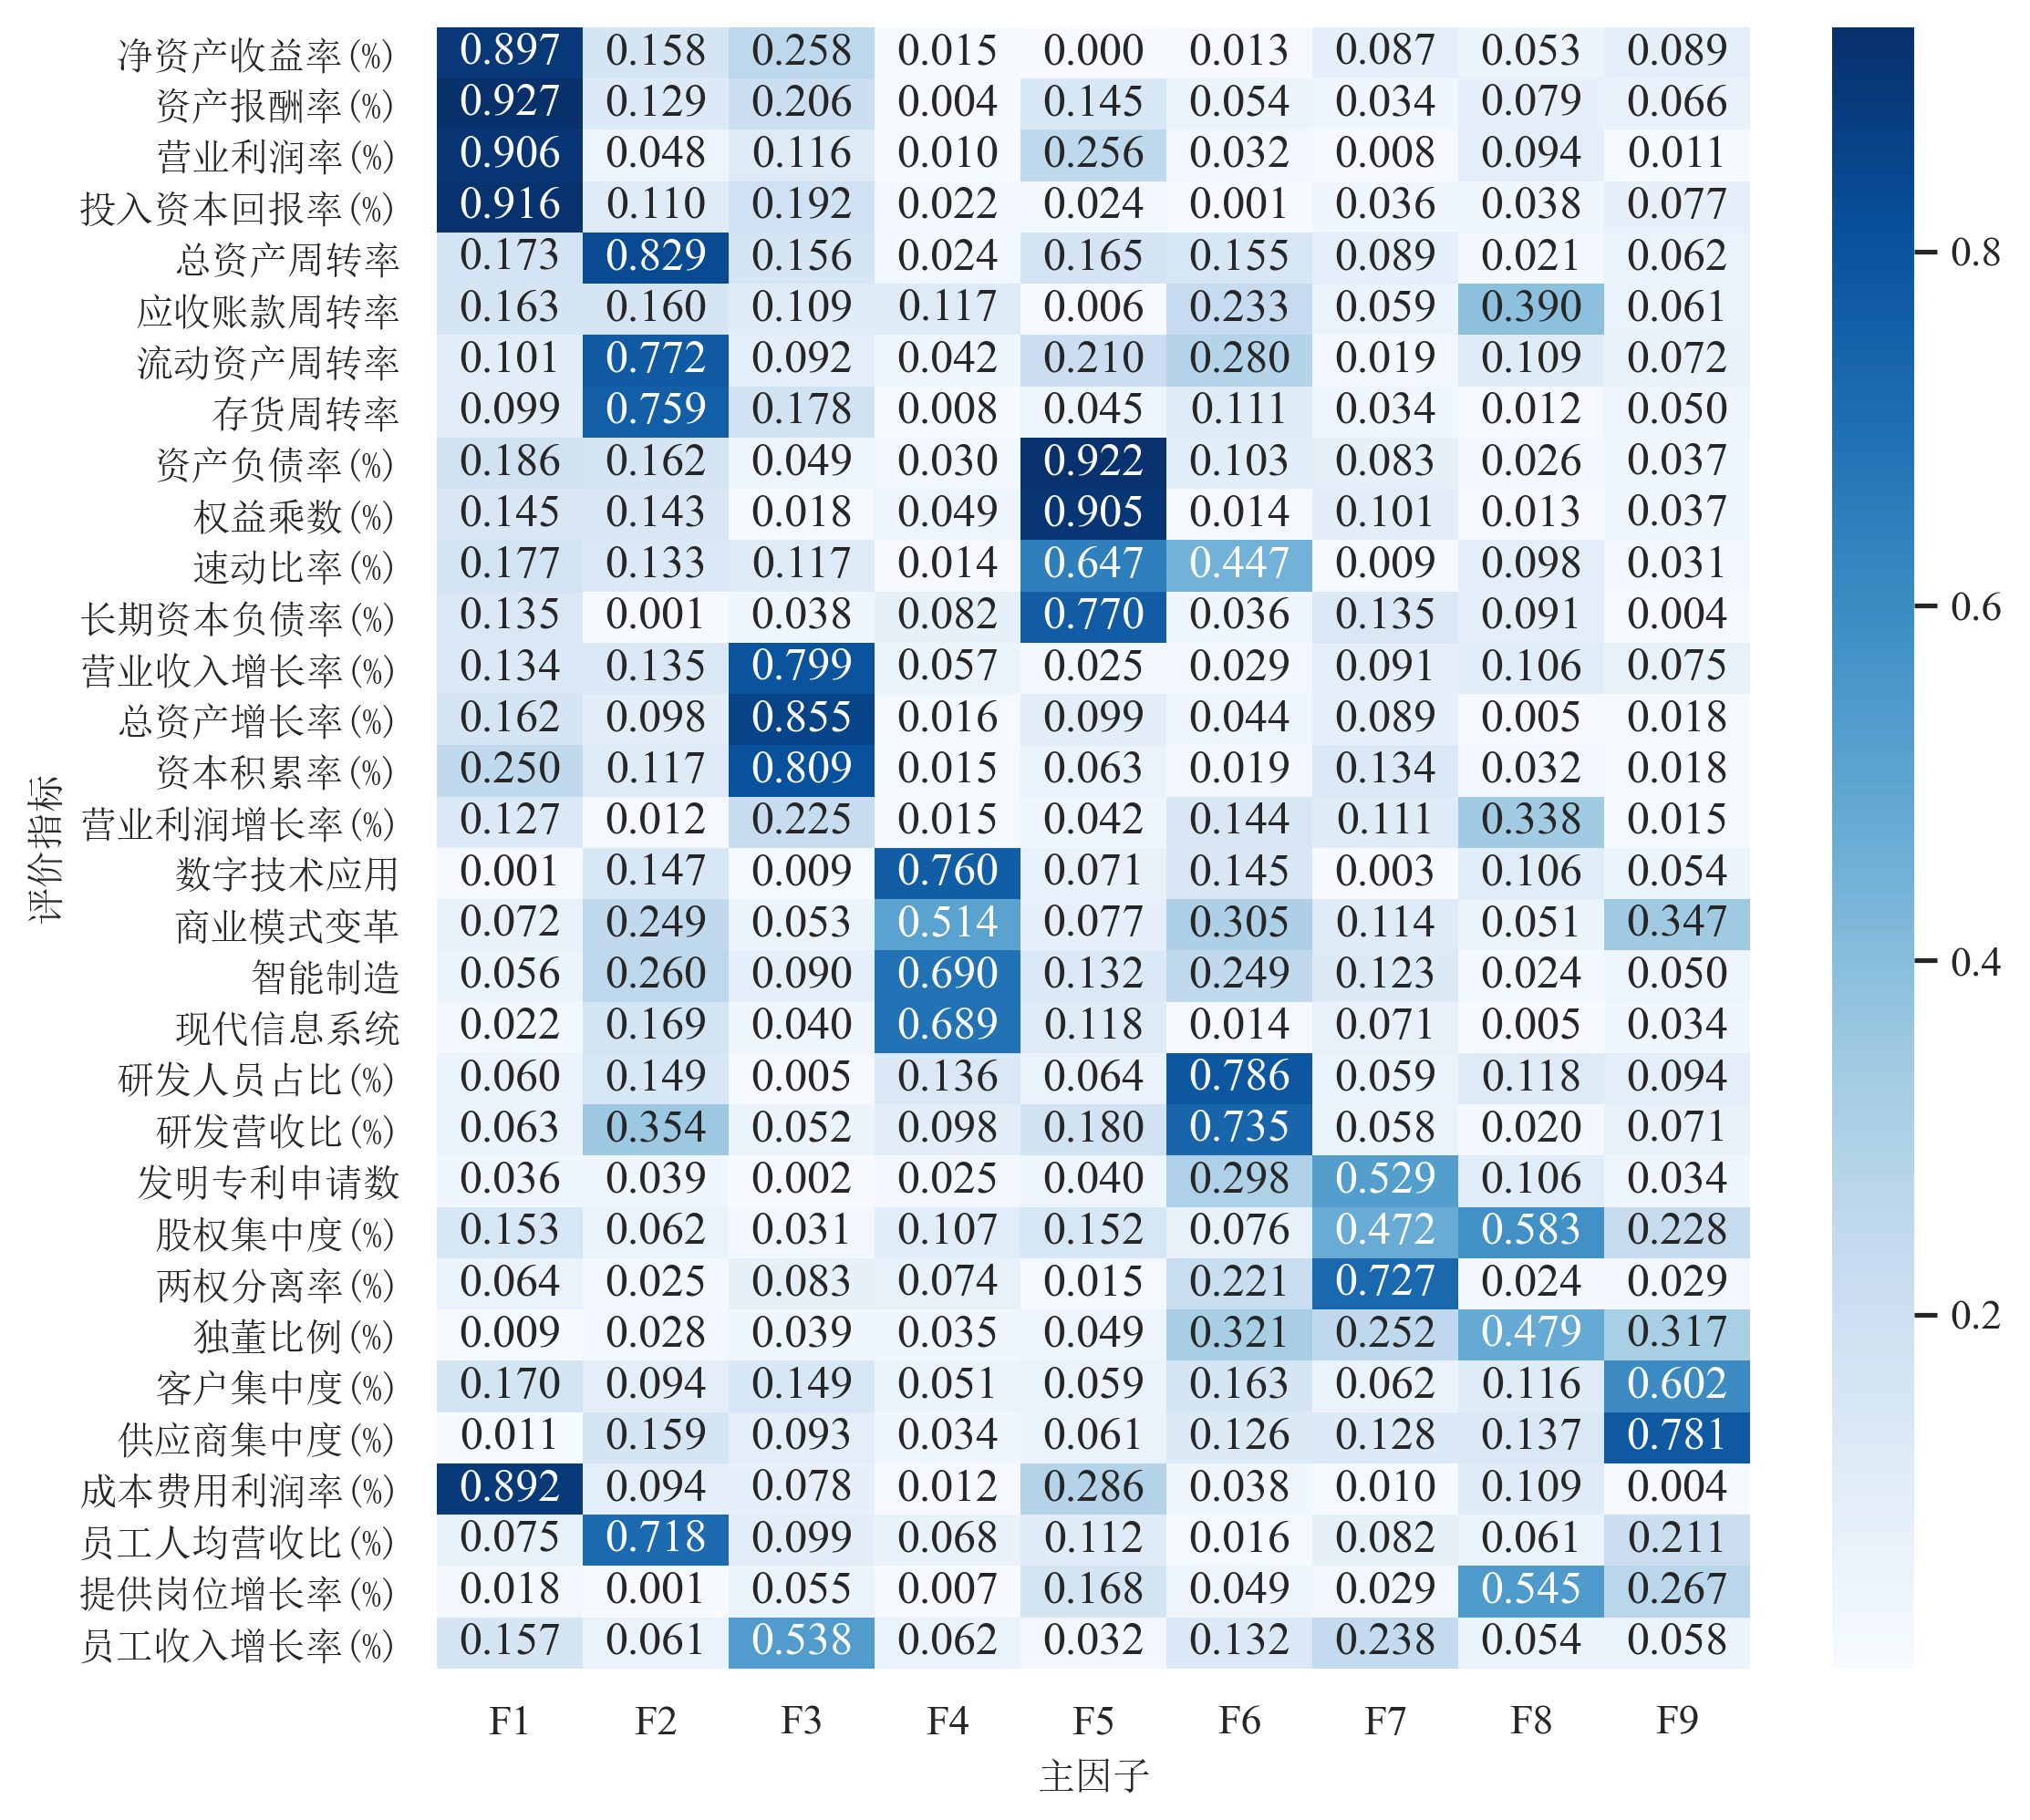

In [6]:
import seaborn as sns
sns.set(font='Times New Roman')

# font = {"fontfamily":"Songti SC", "fontsize":10}  
font = {"fontsize":10, "fontfamily": "simsun"} 
fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.abs(fa.loadings_), cmap='Blues', annot=True, fmt='.3f', ax=ax, annot_kws={"fontfamily": "Times New Roman", "fontsize": 12}, xticklabels=[f'F{i+1}' for i in range(n_factors)], yticklabels=data.columns)
ax.set_xlabel('主因子', fontdict=font)
ax.set_ylabel('评价指标', fontdict=font)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font)
plt.tight_layout()
plt.savefig(base_path/'imgs/旋转后的载荷矩阵.svg', transparent=True, pad_inches=0.0, bbox_inches='tight')
plt.show()

In [7]:
# 计算最终因子得分-形成训练数据

# aa1 = fa.transform(matrix).dot(eig_df['方差贡献率(%)'][:n_factors].to_numpy())
# weights_ = np.linalg.solve(fa.corr_, fa.loadings_)
# X_scale = (metrix - np.mean(metrix, axis=0)) / np.std(metrix, axis=0)
# aa2 = X_scale.dot(weights_.dot(eig_df['方差贡献率(%)'][:n_factors].to_numpy()))
# weights_.shape
# _w = weights_.dot(eig_df['方差贡献率(%)'][:n_factors].to_numpy())

data2023["因子得分"] = fa.transform(data).dot(eig_df['方差贡献率(%)'][:n_factors].to_numpy())
data2023.to_csv('./data/dataset.csv', index=False)
data2023.head(10)

,股票代码,股票简称,行业代码,所属省份,数字技术应用,商业模式变革,智能制造,现代信息系统,资产负债率(%),权益乘数(%),...,研发人员占比(%),研发营收比(%),发明专利申请数,独董比例(%),现金资产比率(%),员工人均营收比(%),提供岗位增长率(%),员工收入增长率(%),董事会规模,因子得分
0,000030,富奥股份,36,吉林省,19.0,0.0,13.0,1.0,0.303249,1.928722,...,14.50,3.60,4.382027,0.333333,0.002607,1.985789,-1.360040,42.606409,2.302585,19.778331
1,000049,德赛电池,38,广东省,8.0,0.0,9.0,2.0,0.171267,2.587350,...,12.97,3.17,3.970292,0.333333,0.175848,1.854367,-1.219072,-24.462585,2.302585,27.799750
2,000333,美的集团,38,广东省,112.0,38.0,82.0,5.0,0.143384,2.788521,...,11.69,3.92,0.000000,0.333333,0.119132,1.881598,19.471497,26.898093,2.302585,26.838360
3,000338,潍柴动力,36,山东省,5.0,3.0,17.0,0.0,0.121904,2.966189,...,16.81,4.20,0.000000,0.333333,0.082187,4.492755,2.542957,21.121106,2.772589,-4.197352
4,000400,许继电气,38,河南省,12.0,0.0,24.0,2.0,0.318638,1.873126,...,44.27,4.65,0.000000,0.333333,0.125469,3.013760,0.159236,16.945259,2.302585,21.731384
5,000401,冀东水泥,30,河北省,13.0,3.0,25.0,3.0,0.295373,1.958471,...,2.85,0.45,0.000000,0.375000,0.049894,1.277493,-1.264239,-60.214415,2.197225,-28.453546
6,000425,徐工机械,35,江苏省,22.0,17.0,47.0,2.0,0.139641,2.817935,...,24.20,5.43,0.000000,0.333333,0.022043,3.303854,2.352770,-6.010331,2.302585,-8.912642
7,000521,长虹美菱,38,安徽省,6.0,4.0,12.0,3.0,0.104189,3.130690,...,15.07,2.90,0.000000,0.333333,0.107384,1.501497,12.756598,27.418054,2.302585,13.504771
8,000528,柳工,35,广西壮族自治区,14.0,2.0,38.0,0.0,0.171146,2.588156,...,11.76,3.80,4.736198,0.363636,0.034973,1.655186,0.836972,21.062716,2.484907,-16.164393
9,000533,顺钠股份,38,广东省,23.0,0.0,11.0,0.0,0.130086,2.895908,...,27.41,3.90,0.000000,0.333333,0.074447,1.543632,6.948882,10.656053,2.302585,-2.952841
